# PyCUDA-图像处理-HDR

In [1]:
import pycuda.autoinit
import pycuda.driver as cu
from pycuda import gpuarray
from pycuda.reduction import ReductionKernel
from pycuda.elementwise import ElementwiseKernel
import time
import numpy as np
from pycuda.compiler import SourceModule
import string
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [2]:
def load_kernel_from_file(fname,kname):
    sources = None
    kernel = None
    with open(fname) as f:
        sources = f.read() # 通过str函数转换为unicode编码
        sm = SourceModule(str(sources))
        kernel = sm.get_function(kname)
    return kernel

def load_kernel_from_string(sources,kname):
    sm = SourceModule(str(sources))
    kernel = sm.get_function(kname)
    return kernel

In [ ]:
# separateChannels = load_kernel_from_file('../../datas/cuda/24-hdr.cu','separateChannels')
# rgb_to_xyY = load_kernel_from_file('../../datas/cuda/24-hdr.cu','rgb_to_xyY')
# kernel_scan = load_kernel_from_file('../../datas/cuda/24-hdr.cu','kernel_scan')
# kernel_histo = load_kernel_from_file('../../datas/cuda/24-hdr.cu','kernel_histo')
# kernel_maxmin = load_kernel_from_file('../../datas/cuda/24-hdr.cu','kernel_maxmin')
# tonemap = load_kernel_from_file('../../datas/cuda/24-hdr.cu','tonemap')
# separateChannels = load_kernel_from_file('../../datas/cuda/24-hdr.cu','separateChannels')
# recombineChannels = load_kernel_from_file('../../datas/cuda/24-hdr.cu','recombineChannels')
# normalize_cdf = load_kernel_from_file('../../datas/cuda/24-hdr.cu','normalize_cdf')

In [357]:
luminance_kernel = load_kernel_from_file('../../datas/cuda/24-hdr-2.cu','luminance_kernel')
downsample_kernel = load_kernel_from_file('../../datas/cuda/24-hdr-2.cu','downsample_kernel')
blur_kernel_y = load_kernel_from_file('../../datas/cuda/24-hdr-2.cu','blur_kernel_y')
blur_kernel_x = load_kernel_from_file('../../datas/cuda/24-hdr-2.cu','blur_kernel_x')
tonemap_kernel = load_kernel_from_file('../../datas/cuda/24-hdr-2.cu','tonemap_kernel')

In [358]:
rgb = cv2.cvtColor(cv2.imread('../../datas/sunset.jpg'),cv2.COLOR_BGR2RGB)
rgba = cv2.cvtColor(rgb,cv2.COLOR_RGB2RGBA)
gray = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)

In [ ]:
# def findmaxmin(d_in,size,maxmin):
#     block_size = 32
#     curr_size = size
#     d_curr_in = d_in.copy().astype(np.float32)
#     while True:
#         newSize = curr_size // block_size + 1
#         print(newSize)
#         threads = (newSize,1,1)
#         blocks = (32,1,1)
#         d_out = np.zeros(int(newSize),dtype=np.float32)
#         kernel_maxmin(cu.In(d_curr_in),cu.Out(d_out),
#                         np.int32(curr_size),
#                          np.int32(maxmin),
#                          grid=threads,block=blocks)
#         d_curr_in = d_out.copy()
#         if newSize == 1:
#             break
#         curr_size = newSize
#     return d_out.copy()

In [ ]:
# def preprocess(d_image,numRows,numCols,numberOfBins):
#     numBins = 1024
#     blockSize = (32,32,1)
#     gridSize = (int(numCols / blockSize[0] + 1),int(numRows/blockSize[1] + 1))
#     d_red = np.zeros((numRows,numCols),dtype=np.float32)
#     d_green = np.zeros_like(d_red)
#     d_blue = np.zeros_like(d_green)
#     separateChannels(cu.In(d_image),np.int32(numRows),np.int32(numCols),
#                     cu.Out(d_red),cu.Out(d_green),cu.Out(d_blue),
#                     grid=gridSize,block=blockSize)
#     d_x = np.zeros_like(d_red)
#     d_y = np.zeros_like(d_x)
#     d_logY = np.zeros_like(d_y)
    
#     rgb_to_xyY(cu.In(d_red),cu.In(d_green),cu.In(d_blue),
#               cu.Out(d_x),cu.Out(d_y),cu.Out(d_logY),
#               np.float32(0.0001),np.int32(numRows),np.int32(numCols),
#               grid=gridSize,block=blockSize)
#     d_cdf = np.zeros(int(numBins),dtype=np.uint32)
#     return d_logY,numBins,d_cdf.copy()

In [ ]:
# def toneMap(d_logLuminance,d_cdf,numRows,numCols,numBins):
#     min_logLum = findmaxmin(d_logLuminance,numRows * numCols,0)
#     max_logLum = findmaxmin(d_logLuminance,numRows * numCols,1)
    
#     d_bins = np.zeros(int(numBins),dtype=np.int32)
#     size = numRows * numCols
#     threads = (1024,1,1)
#     blocks = (int(size / threads[0] + 1),1,1)

In [359]:
rows,cols,ch = rgb.shape
block = (32,32,1)
grid = (int(cols/ block[0]),int(rows / block[1]))

In [360]:
def luminance(src,cols,rows):
    dst = np.zeros((rows,cols),dtype=np.float32)
    block = (32,32,1)
    grid = (int(cols/ block[0]),int(rows / block[1]))
    luminance_kernel(cu.Out(dst),
                    cu.In(src.astype(np.float32)),
                    np.int32(cols),np.int32(rows),
                    grid=grid,block=block)
    return dst

In [361]:
dst_luminance = luminance(rgb,cols,rows)

Text(0.5,1,'Luminance')

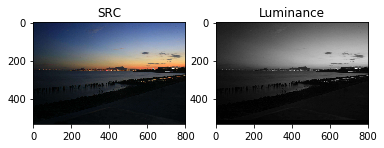

In [362]:
plt.subplot(121)
plt.imshow(rgb)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst_luminance.astype(np.uint8),'gray')
plt.title('Luminance')

In [363]:
def downsample(luminance_data,cols,rows):
    block = (32,32,1)
    grid = (int(cols/ block[0]),int(rows / block[1]))
    dst = np.zeros((rows,cols),dtype=np.float32)
    pitchBuf = cols // 2
    pitchLuminance = cols
    downsample_kernel(cu.Out(dst),cu.In(luminance_data),
                     np.int32(cols),np.int32(rows),
                     np.int32( pitchBuf),np.int32(pitchLuminance),
                     grid=grid,block=block)
    width = cols
    height = rows
    ping = False
    while width != 1 or height != 1:
        width = width // 2
        height = height // 2
        if width < 1:
            width = 1
        if height < 1:
            height = 1
        if ping:
            downsample_kernel(cu.Out(dst),cu.In(luminance_data),
                     np.int32(cols),np.int32(rows),
                     np.int32( pitchBuf),np.int32(pitchLuminance),
                     grid=grid,block=block)
        else:
            downsample_kernel(cu.Out(dst),cu.In(luminance_data),
                     np.int32(cols),np.int32(rows),
                     np.int32( pitchLuminance),np.int32(pitchBuf),
                     grid=grid,block=block)
        ping = ~ping
    return dst[0,0] # 返回

In [364]:
lum = downsample(dst_luminance,cols,rows)
print(lum)

46.095


In [365]:
def gaussian_blur(src,cols,rows):
    block = (32,32,1)
    grid = (int(cols/ block[0]),int(rows / block[1]))
    inputPitch = cols;
    outputPitch = cols;
    dst_x = np.zeros(src.shape,dtype=np.float32)
    dst = np.zeros(src.shape,dtype=np.float32)
    blur_kernel_x(cu.Out(dst_x),cu.In(src.astype(np.float32)),
                 np.int32(cols),np.int32(rows),
                 np.int32(inputPitch),np.int32(outputPitch),
                 grid=grid,block=block)
    blur_kernel_y(cu.Out(dst),cu.In(dst_x),
                 np.int32(cols),np.int32(rows),
                 np.int32(inputPitch),np.int32(outputPitch),
                 grid=grid,block=block)
    return dst

In [366]:
dst_blured = gaussian_blur(rgb,cols,rows)

Text(0.5,1,'Guassian Blur')

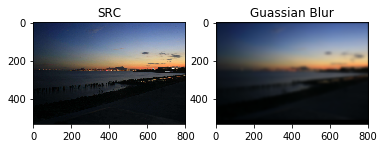

In [367]:
plt.subplot(121)
plt.imshow(rgb)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst_blured.astype(np.uint8))
plt.title('Guassian Blur')

In [368]:
def tonemap(src,cols,rows,exposure=0.0,brightness_threshold=0.9):
    block = (32,32,1)
    grid = (int(cols/ block[0]),int(rows / block[1]))
    tonemapped = np.zeros(src.shape,dtype=np.float32)
    brightpass = np.zeros(src.shape,dtype=np.float32)
    tonemap_kernel(cu.Out(tonemapped),cu.Out(brightpass),cu.In(src.astype(np.float32)),
                  np.int32(cols),np.int32(rows),np.float32(exposure),np.float32(brightness_threshold),
                  grid=grid,block=block)
    return tonemapped.copy(),brightpass.copy()

In [369]:
tonemapped,brightpass =tonemap(rgb,cols,rows,exposure=0.01,brightness_threshold=0.1)

Text(0.5,1,'Brightness Pass')

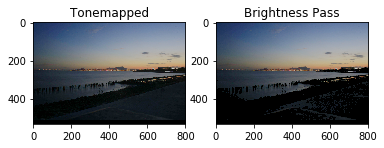

In [370]:
plt.subplot(121)
plt.imshow((tonemapped * 255).astype(np.uint8))
plt.title('Tonemapped')
plt.subplot(122)
plt.imshow((brightpass * 255).astype(np.uint8))
plt.title('Brightness Pass')

In [371]:
dst_luminance = luminance(rgb,cols,rows)

In [372]:
lum = downsample(dst_luminance,cols,rows)
print('lum = ',lum)

lum =  46.095


In [401]:
exposure = 255
brightpass_threshold = 0.9
dst_tonemapped,dst_brightpass = tonemap(rgb,cols,rows,0.015,brightpass_threshold)

In [383]:
dst_blured = gaussian_blur(dst_tonemapped,cols,rows)

In [402]:
dst = dst_tonemapped + dst_brightpass
dst = dst * 255
dst[dst < 0] = 0
dst[dst > 255] = 255
dst = dst.astype(np.uint8)
dst_br = dst_brightpass * 255
dst_br[dst_br < 0] = 0
dst_br[dst_br > 255] = 255
dst_br = dst_br.astype(np.uint8)

True

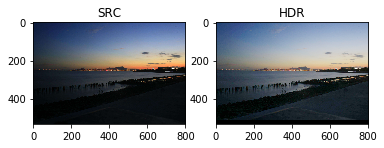

In [403]:
plt.subplot(121)
plt.imshow(rgb)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst)
plt.title('HDR')
cv2.imwrite('../../temp/hdr.jpg',cv2.cvtColor(dst,cv2.COLOR_RGB2BGR))

In [287]:
dst = dst_tonemapped + dst_brightpass
dst = dst * 255
dst[dst < 0] = 0
dst[dst > 255] = 255
dst = dst.astype(np.uint8)

True

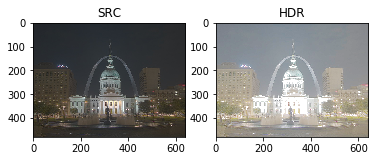

In [288]:
plt.subplot(121)
plt.imshow(rgb)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst)
plt.title('HDR')
cv2.imwrite('../../temp/hdr2.jpg',cv2.cvtColor(dst,cv2.COLOR_RGB2BGR))

In [404]:
print(dst_brightpass)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
